## **Name**: Shaurya Bansal
## **Email**: sbansal8_be21@thapar.edu
## **Roll No**: 102103012
## **Group**: 4CO1  

## **Task**

Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.

# Importing Libraries


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Importing the Speech Commands dataset


In [ ]:
DATASET_PATH = 'archive'

data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
all_commands = commands[(commands != 'README.md') & (commands != 'testing_list.txt')& (commands != 'validation_list.txt') & (commands!= 'LICENSE')]
commands = commands[(commands != 'README.md') & (commands != 'testing_list.txt')& (commands != 'validation_list.txt') & (commands != 'background_noise') & (commands!= 'LICENSE')]
print('Commands:', commands)

Commands: ['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero' '_background_noise_']


In [ ]:
commands.size

36

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 105824 files belonging to 36 classes.
Using 84660 files for training.
Using 21164 files for validation.

label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


### plotting a few audio waveforms:

In [ ]:
label_names[[1,1,3,0]]

array(['backward', 'backward', 'bird', '_background_noise_'], dtype='<U18')

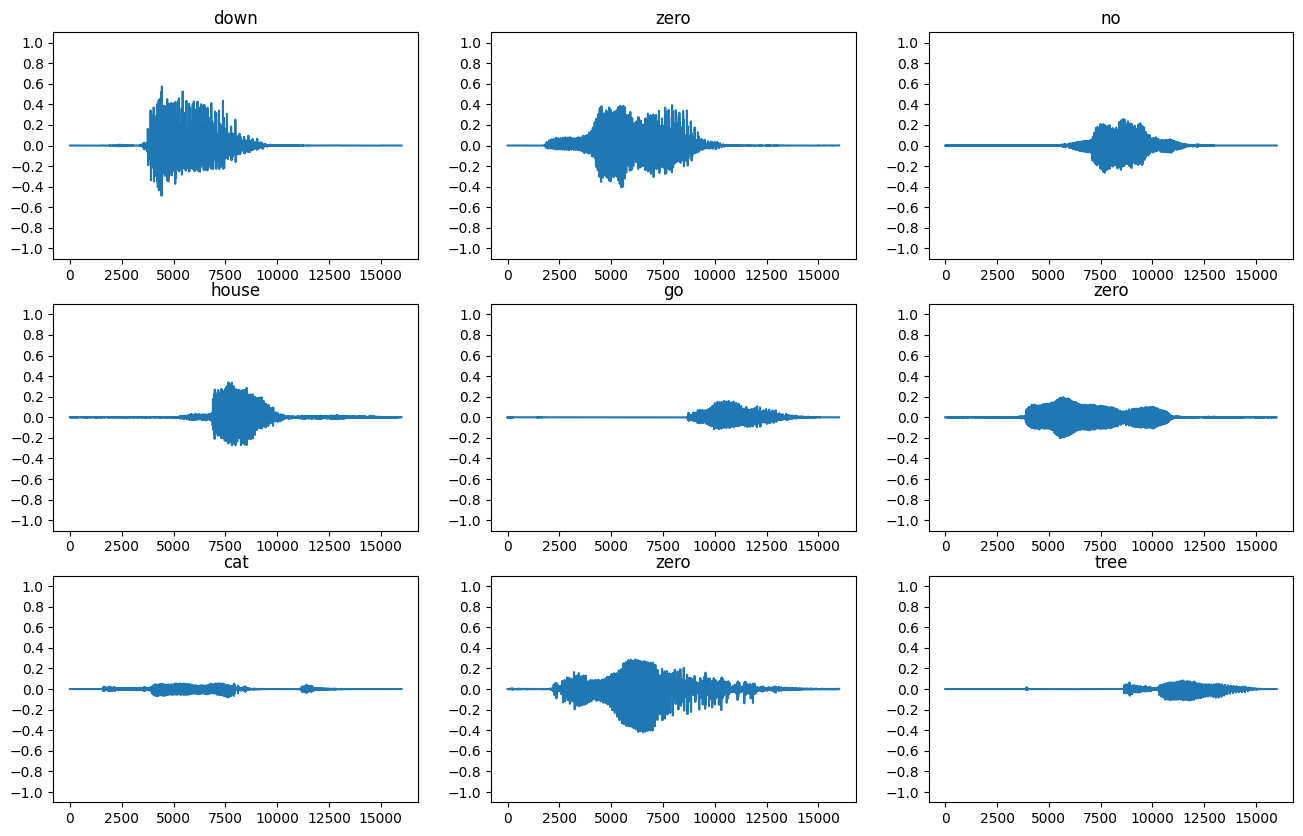

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Statistical Analysis

In [ ]:
from collections import Counter

def count_files_per_class(dataset_dir):
    class_counts = Counter()
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            num_files = len(os.listdir(folder_path))
            class_counts[folder] = num_files
    return class_counts

class_counts = count_files_per_class(data_dir)
print("Number of files per class:\n", class_counts)

Number of files per class:
 Counter({'five': 4052, 'zero': 4050, 'yes': 4044, 'seven': 3994, 'no': 3941, 'nine': 3934, 'down': 3917, 'one': 3890, 'go': 3880, 'two': 3880, 'stop': 3872, 'six': 3860, 'on': 3845, 'left': 3801, 'eight': 3787, 'right': 3778, 'off': 3745, 'four': 3728, 'three': 3725, 'up': 3723, 'dog': 2128, 'wow': 2123, 'house': 2113, 'marvin': 2099, 'bird': 2064, 'happy': 2054, 'cat': 2030, 'sheila': 2022, 'bed': 2013, 'tree': 1759, 'backward': 1664, 'visual': 1592, 'follow': 1579, 'learn': 1575, 'forward': 1557, '_background_noise_': 7})


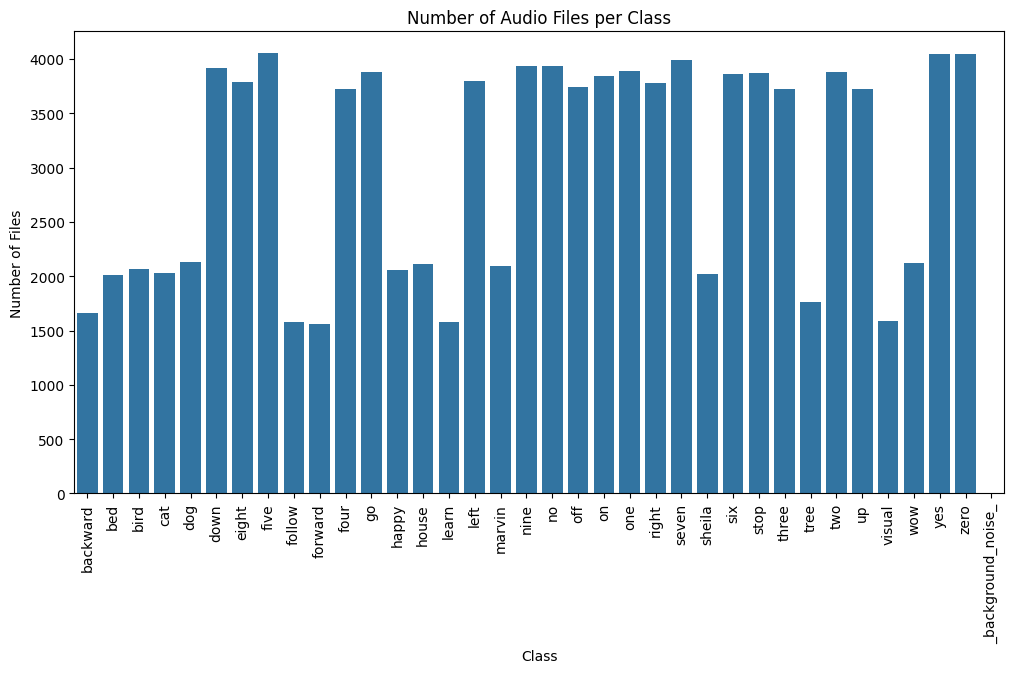

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Number of Audio Files per Class")
plt.xlabel("Class")
plt.ylabel("Number of Files")
plt.show()

In [ ]:
import wave
import mimetypes

In [ ]:
def calculate_duration(file_path):
    mime_type, _ = mimetypes.guess_type(file_path)
    if mime_type == 'audio/x-wav':  # Check if the file is a WAV file
        with wave.open(file_path, 'r') as audio_file:
            frames = audio_file.getnframes()
            rate = audio_file.getframerate()
            duration = frames / float(rate)
        return duration
    else:
        return None

def get_durations_per_class(dataset_dir):
    durations_per_class = {cls: [] for cls in class_counts}
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                duration = calculate_duration(file_path)
                if duration is not None:  # Only add valid durations
                    durations_per_class[folder].append(duration)
    return durations_per_class

durations_per_class = get_durations_per_class(data_dir)

for cls, durations in durations_per_class.items():
    if durations:
        print(f"Class: {cls}, Average Duration: {np.mean(durations):.2f} seconds")
    else:
        print(f"Class: {cls}, No valid audio files found")


Class: backward, No valid audio files found
Class: bed, No valid audio files found
Class: bird, No valid audio files found
Class: cat, No valid audio files found
Class: dog, No valid audio files found
Class: down, No valid audio files found
Class: eight, No valid audio files found
Class: five, No valid audio files found
Class: follow, No valid audio files found
Class: forward, No valid audio files found
Class: four, No valid audio files found
Class: go, No valid audio files found
Class: happy, No valid audio files found
Class: house, No valid audio files found
Class: learn, No valid audio files found
Class: left, No valid audio files found
Class: marvin, No valid audio files found
Class: nine, No valid audio files found
Class: no, No valid audio files found
Class: off, No valid audio files found
Class: on, No valid audio files found
Class: one, No valid audio files found
Class: right, No valid audio files found
Class: seven, No valid audio files found
Class: sheila, No valid audio file

In [ ]:
def get_file_sizes_per_class(dataset_dir):
    sizes_per_class = {cls: [] for cls in class_counts}
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                size = os.path.getsize(file_path) / 1024  # File size in KB
                sizes_per_class[folder].append(size)
    return sizes_per_class

sizes_per_class = get_file_sizes_per_class(data_dir)
for cls, sizes in sizes_per_class.items():
    if sizes:  # Ensure there are durations to calculate stats
        print(f"Class: {cls}, Average Size: {np.mean(sizes):.2f} KB")
    else:
        print(f"Class: {cls}, No valid audio files found")



Class: backward, Average Size: 30.87 KB
Class: bed, Average Size: 30.37 KB
Class: bird, Average Size: 30.34 KB
Class: cat, Average Size: 30.42 KB
Class: dog, Average Size: 30.43 KB
Class: down, Average Size: 30.78 KB
Class: eight, Average Size: 30.69 KB
Class: five, Average Size: 30.80 KB
Class: follow, Average Size: 30.73 KB
Class: forward, Average Size: 30.82 KB
Class: four, Average Size: 30.76 KB
Class: go, Average Size: 30.63 KB
Class: happy, Average Size: 30.50 KB
Class: house, Average Size: 30.51 KB
Class: learn, Average Size: 30.49 KB
Class: left, Average Size: 30.82 KB
Class: marvin, Average Size: 30.60 KB
Class: nine, Average Size: 30.82 KB
Class: no, Average Size: 30.67 KB
Class: off, Average Size: 30.82 KB
Class: on, Average Size: 30.73 KB
Class: one, Average Size: 30.64 KB
Class: right, Average Size: 30.74 KB
Class: seven, Average Size: 30.82 KB
Class: sheila, Average Size: 30.59 KB
Class: six, Average Size: 30.90 KB
Class: stop, Average Size: 30.81 KB
Class: three, Average

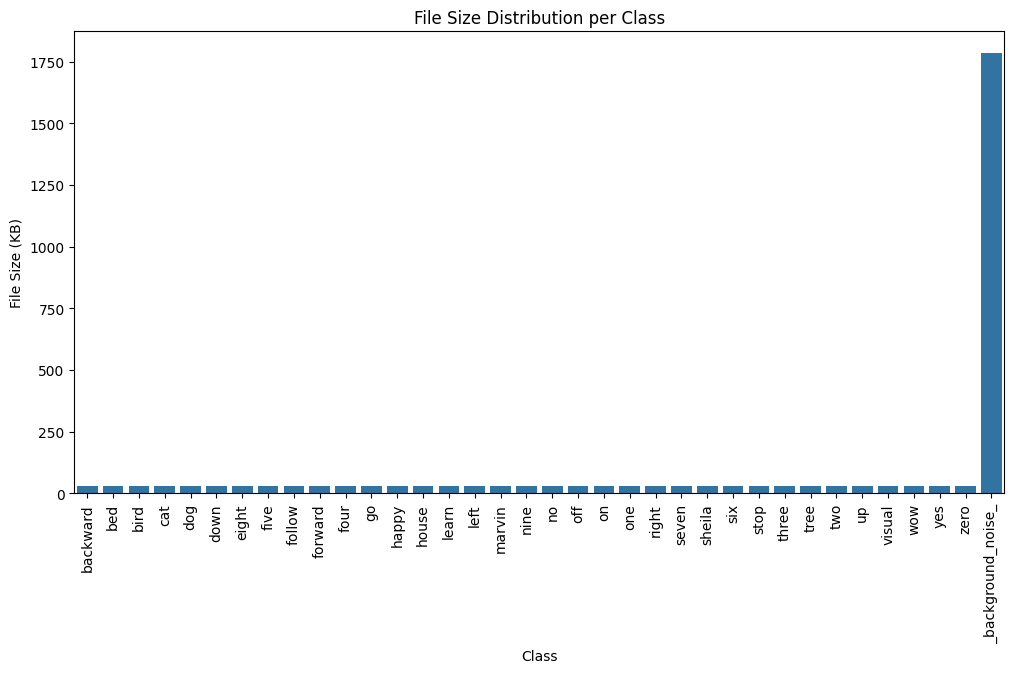

In [ ]:
plt.figure(figsize=(12, 6))
sizes = [np.mean(sizes_per_class[cls]) for cls in sizes_per_class.keys()]
sns.barplot(x=list(sizes_per_class.keys()), y=sizes)
plt.xticks(rotation=90)
plt.title("File Size Distribution per Class")
plt.xlabel("Class")
plt.ylabel("File Size (KB)")
plt.show()

In [ ]:
import tensorflow as tf

def is_valid_wav(file_path):
    """Check if a file is a valid WAV file by trying to decode it."""
    try:
        waveform, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
        return True
    except:
        return False

def get_spectrogram_energies_per_class(dataset_dir):
    energies_per_class = {}
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            energies_per_class[folder] = []
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if is_valid_wav(file_path):  # Check if it's a valid WAV file
                    waveform, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
                    spectrogram = get_spectrogram(tf.squeeze(waveform, axis=-1))
                    energy = calculate_spectrogram_energy(spectrogram)
                    energies_per_class[folder].append(energy)
                else:
                    print(f"Skipping invalid WAV file: {file_path}")
    return energies_per_class


# Converting waveforms to spectograms

In [ ]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: zero
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

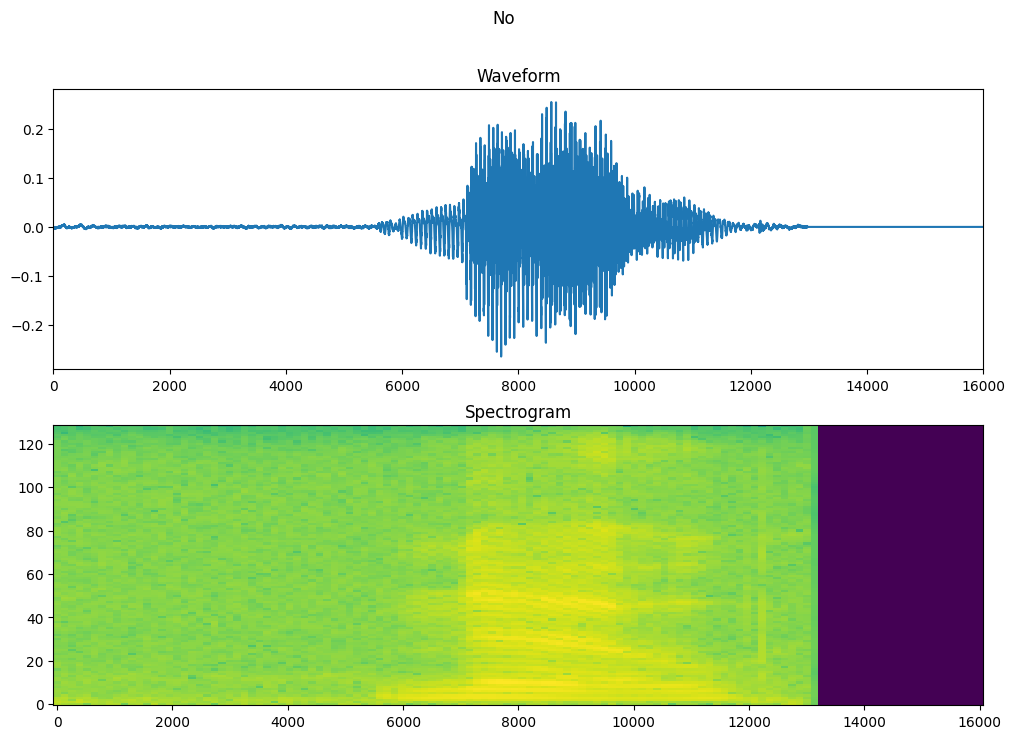

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

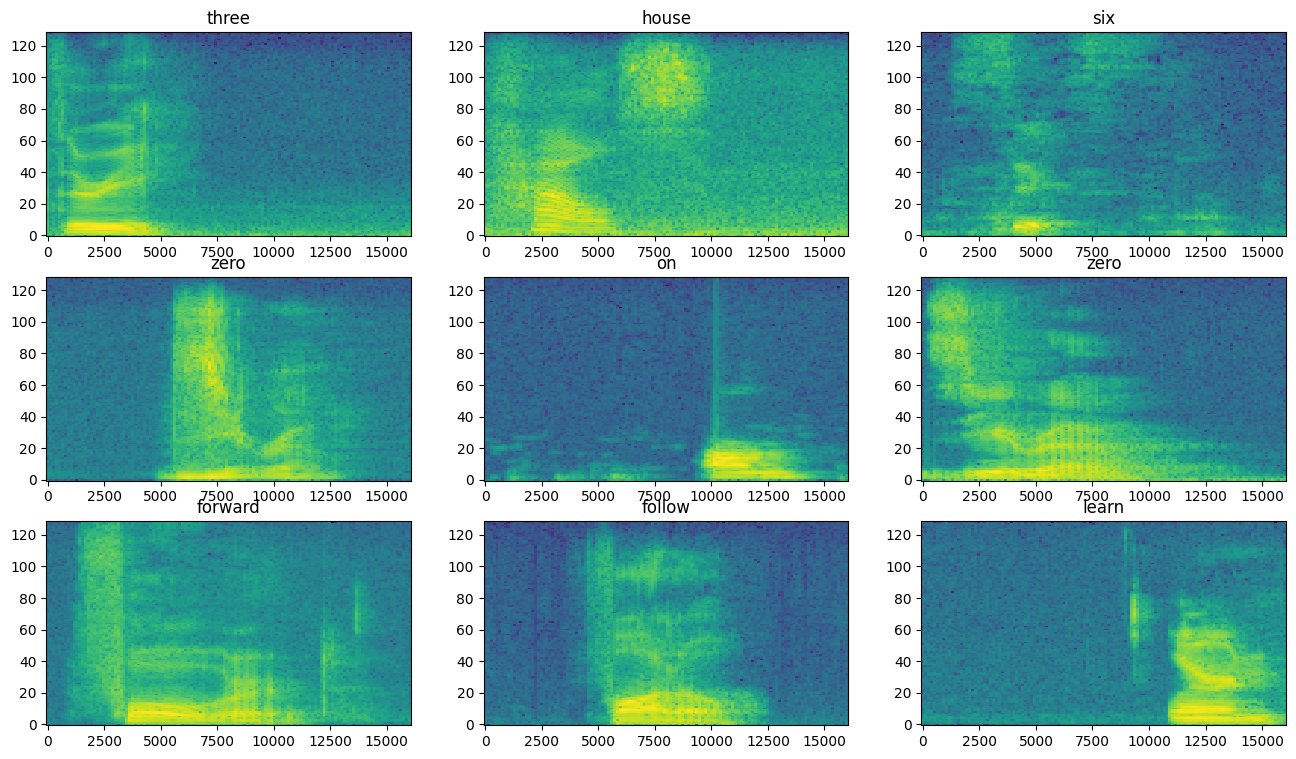

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Build and train the model

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## CNN

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Resizing(32, 32),

    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),  # Batch normalization
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D(),
    layers.Dropout(0.1),  # Lower dropout rate

    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),  # Global pooling

    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_labels),
])



model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 36)                  │           4,6

 Total params: 165,159 (645.16 KB)

 Trainable params: 164,196 (641.39 KB)

 Non-trainable params: 963 (3.77 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
# model.compile(optimizer=AdamW(learning_rate=lr_schedule),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 224s 167ms/step - accuracy: 0.2738 - loss: 2.8602 - val_accuracy: 0.5015 - val_loss: 2.0249
Epoch 2/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 278s 210ms/step - accuracy: 0.6941 - loss: 1.1482 - val_accuracy: 0.8161 - val_loss: 0.7206
Epoch 3/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 276s 208ms/step - accuracy: 0.7608 - loss: 0.9011 - val_accuracy: 0.8330 - val_loss: 0.6368
Epoch 4/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 246s 186ms/step - accuracy: 0.7909 - loss: 0.7930 - val_accuracy: 0.8365 - val_loss: 0.6308
Epoch 5/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 226s 171ms/step - accuracy: 0.8062 - loss: 0.7380 - val_accuracy: 0.7991 - val_loss: 0.7692
Epoch 6/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 274s 179ms/step - accuracy: 0.8155 - loss: 0.6977 - val_accuracy: 0.8636 - val_loss: 0.5248
Epoch 7/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 239s 181ms/step - accuracy: 0.8248 - loss: 0.6652 - val_accuracy: 0.8533 - val_loss: 0.5546
Epoch 8/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 242s 183ms/step - ac

Text(0, 0.5, 'Accuracy [%]')

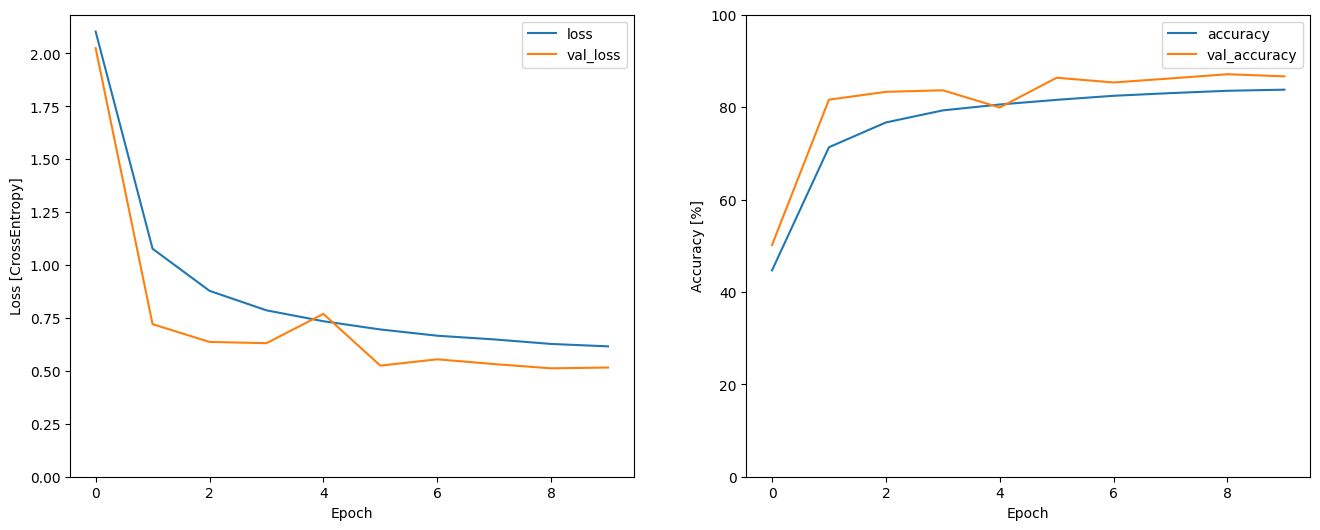

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Evaluating the model performance

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8728 - loss: 0.4982


{'accuracy': 0.8706148862838745, 'loss': 0.5077883005142212}

## Displaying a confusion matrix


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

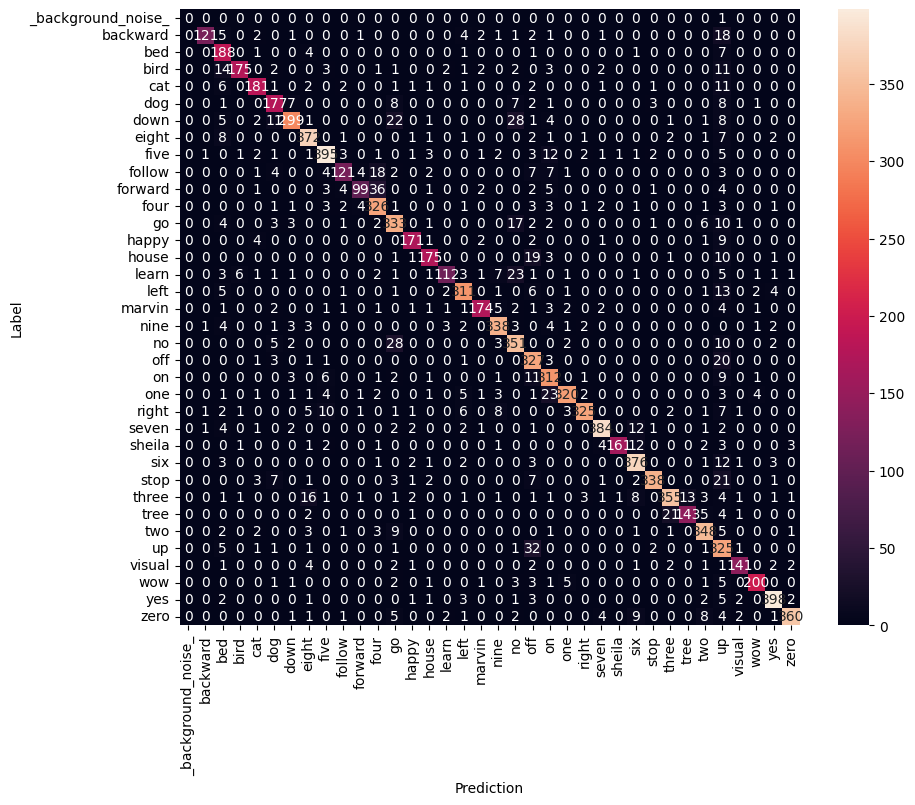

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
new_label_names = label_names[label_names!='_background_noise_']

In [ ]:
print("\nClassification Report:\n")
report = classification_report(y_true, y_pred, target_names=label_names)
print(report)


Classification Report:

                    precision    recall  f1-score   support

_background_noise_       0.00      0.00      0.00         1
          backward       0.97      0.76      0.85       160
               bed       0.71      0.93      0.80       203
              bird       0.95      0.80      0.87       219
               cat       0.89      0.86      0.87       211
               dog       0.80      0.82      0.81       215
              down       0.92      0.78      0.84       384
             eight       0.89      0.93      0.91       400
              five       0.91      0.90      0.91       439
            follow       0.88      0.70      0.78       174
           forward       0.89      0.63      0.74       158
              four       0.83      0.92      0.87       354
                go       0.78      0.86      0.82       386
             happy       0.91      0.90      0.90       191
             house       0.90      0.83      0.86       211
             l

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
print(label_names)
label_names.size

['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


36

In [ ]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8831
Recall: 0.8706
F1 Score: 0.8726


C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

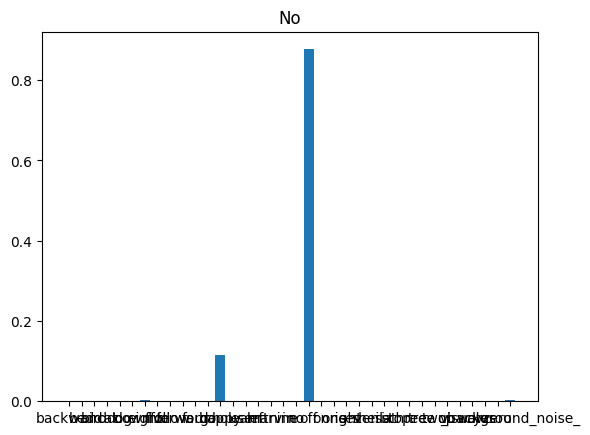

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = all_commands
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[-25.893757  ,  -8.149213  ,  -5.7203555 ,  -0.4510827 ,
          -6.1539745 ,   1.7388558 ,   3.2249377 ,  -3.83834   ,
          -7.5874114 ,  -2.3394086 ,  -5.895849  ,  -0.71757364,
           6.6897874 , -10.38868   ,  -1.7602098 ,   2.025753  ,
          -4.56869   ,  -2.7276077 ,  -0.8768633 ,   8.731533  ,
          -4.40669   ,  -5.680278  ,  -3.5609565 ,  -5.1956363 ,
          -5.995367  ,  -4.0708113 ,  -8.953023  ,  -3.4862092 ,
          -6.7567983 ,  -9.9137535 ,   1.20323   ,  -5.109272  ,
          -0.09805903,   0.53409946,  -1.5884304 ,   2.7851675 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([19], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[-25.893757  ,  -8.149213  ,  -5.7203555 ,  -0.4510827 ,
          -6.1539745 ,   1.7388558 ,   3.2249377 ,  -3.83834   ,
          -7.5874114 ,  -2.3394086 ,  -5.895849  ,  -0.71757364,
           6.6897874 , -10.38868   ,  -1.7602098 ,   2.025753  ,
          -4.56869   ,  -2.7276077 ,  -0.8768633 ,   8.731533  ,
          -4.40669   ,  -5.680278  ,  -3.5609565 ,  -5.1956363 ,
          -5.995367  ,  -4.0708113 ,  -8.953023  ,  -3.4862092 ,
          -6.7567983 ,  -9.9137535 ,   1.20323   ,  -5.109272  ,
          -0.09805903,   0.53409946,  -1.5884304 ,   2.7851675 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([19], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [ ]:
train_ds_fine, val_ds_fine = tf.keras.utils.audio_dataset_from_directory(
    directory='audio_dataset',
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

Found 1712 files belonging to 34 classes.
Using 1370 files for training.
Using 342 files for validation.


In [ ]:
train_ds_fine = train_ds_fine.map(squeeze, tf.data.AUTOTUNE)
val_ds_fine = val_ds_fine.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds_fine = val_ds_fine.shard(num_shards=2, index=0)
val_ds_fine = val_ds_fine.shard(num_shards=2, index=1)

In [ ]:
train_spectrogram_ds_fine = make_spec_ds(train_ds_fine)
val_spectrogram_ds_fine = make_spec_ds(val_ds_fine)
test_spectrogram_ds_fine = make_spec_ds(test_ds_fine)

In [ ]:
train_spectrogram_ds_fine = train_spectrogram_ds_fine.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds_fine = val_spectrogram_ds_fine.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds_fine = test_spectrogram_ds_fine.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
model.save('model.keras')

In [ ]:
import_model = tf.keras.models.load_model('model.keras')

In [ ]:
for layer in import_model.layers[:-2]:  # Adjust the number of layers to freeze based on your model
    layer.trainable = False

In [ ]:
import_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Smaller learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
import_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 36)                  │           4,6

 Total params: 165,159 (645.16 KB)

 Trainable params: 4,644 (18.14 KB)

 Non-trainable params: 160,515 (627.02 KB)

In [ ]:
history = model.fit(train_spectrogram_ds_fine,
                    validation_data=val_spectrogram_ds_fine,
                    epochs=10,  # Set your desired number of epochs
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9859 - loss: 0.1090 - val_accuracy: 0.9533 - val_loss: 0.2300
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9790 - loss: 0.1209 - val_accuracy: 0.8933 - val_loss: 0.3748
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9844 - loss: 0.1109 - val_accuracy: 0.9400 - val_loss: 0.2123
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9825 - loss: 0.1227 - val_accuracy: 0.9733 - val_loss: 0.1186
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9865 - loss: 0.1106 - val_accuracy: 0.9933 - val_loss: 0.1023
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9858 - loss: 0.1087 - val_accuracy: 0.9933 - val_loss: 0.0934
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9832 - loss: 0.1118 - val_accuracy: 1.0000 - val_loss: 0.0753
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9941 - loss: 0.0964 - val_accuracy: 0.966

Text(0, 0.5, 'Accuracy [%]')

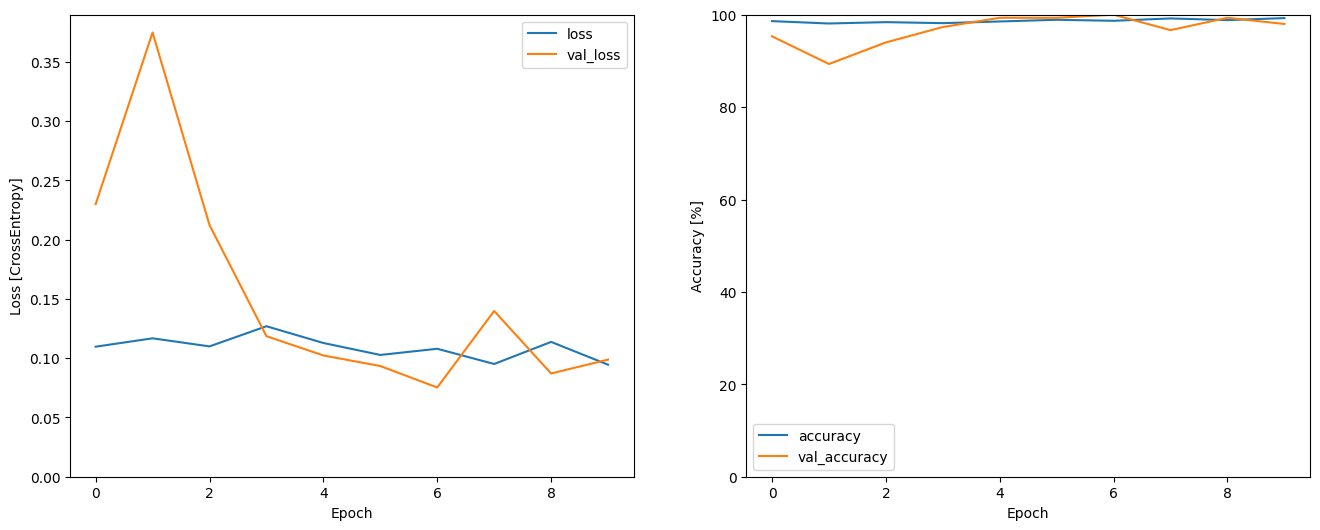

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrogram_ds_fine, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9824 - loss: 0.1170


{'accuracy': 0.984375, 'loss': 0.1167295053601265}

In [ ]:
y_pred = model.predict(test_spectrogram_ds_fine)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds_fine.map(lambda s,lab: lab)), axis=0)

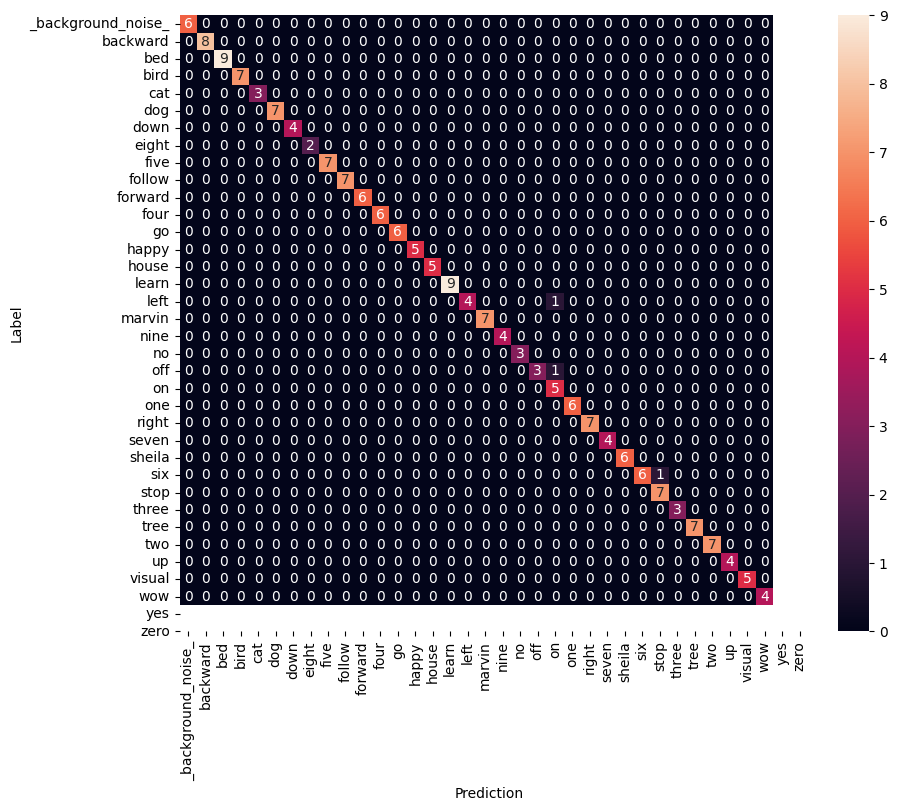

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9880
Recall: 0.9844
F1 Score: 0.9846


In [ ]:
export_fine_tuned = ExportModel(import_model)
tf.saved_model.save(export_fine_tuned, "fine_tuned_model")

INFO:tensorflow:Assets written to: fine_tuned_model\assets


INFO:tensorflow:Assets written to: fine_tuned_model\assets


Predicted class: cat


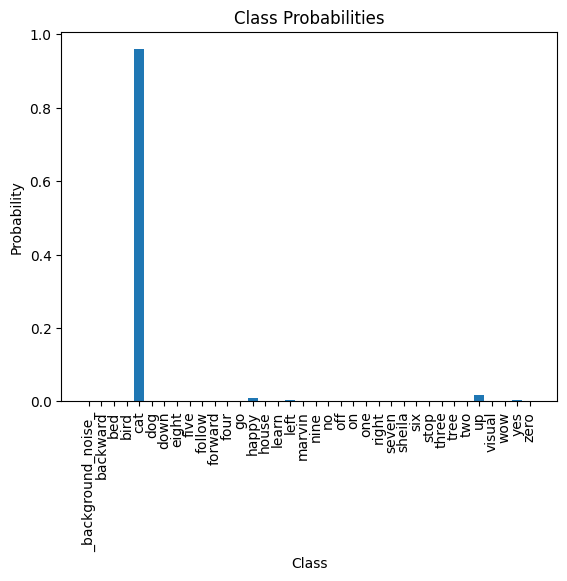

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

x = 'audio_dataset/cat/cat_2.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = import_model(x)

probabilities = tf.nn.softmax(prediction[0])

predicted_class_idx = tf.argmax(probabilities).numpy()
predicted_class_name = label_names[predicted_class_idx]

print(f'Predicted class: {predicted_class_name}')

plt.bar(label_names, probabilities.numpy())
plt.title('Class Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=90)
plt.show()

display.display(display.Audio(waveform, rate=16000))